In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import re
from collections import Counter
import distance
import matplotlib.pyplot as plt

In [2]:
#Functions
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(name),'fasta')
    data = []
    for fasta in fasta_seqs:
        if not ('mitochondrion' in fasta.description or 'plastid' in fasta.description or 'chloroplast' in fasta.description): #Considering only nuclear chromosomes, removing mitochondrial and plastid/chloroplast genomes
            data.append([fasta.id, str(fasta.seq).strip().upper()])
            
    return data
    
def pam_to_search(pam, iupac_code):
    pam_string = list(pam)
    pam_seq = []
    for i in range(len(pam_string)):
        curr_char = iupac_code[pam_string[i]].split('|')
        if i == 0:
            pam_seq = curr_char
        else:
            curr_pam_seq = []
            for j in range(len(curr_char)):
                for k in range(len(pam_seq)):
                    curr_pam_seq.append(pam_seq[k]+curr_char[j])
                    
            pam_seq = curr_pam_seq
    
    return pam_seq

def grna_search(genome, pam_l, glen, orient):
    grna_list = []
    #'for' loop for pam sequences
    for i in range(len(pam_l)):
        curr_pam = pam_l[i]
        
        #'for' loop for chromosomes
        for j in range(len(genome)):
            #top_strand
            chrom_seq = genome[j][1]
            if orient == '3prime':
                curr_grna_loc = [x - glen for x in [m.start() for m in re.finditer(curr_pam, chrom_seq)]]
            else: 
                curr_grna_loc = [m.start() for m in re.finditer(curr_pam, chrom_seq)]
                
            for k in range(len(curr_grna_loc)):
                if curr_grna_loc[k] > -1 and curr_grna_loc[k] < len(chrom_seq) - glen - len(curr_pam):
                    grna_list.append([chrom_seq[curr_grna_loc[k]:curr_grna_loc[k] + glen + len(curr_pam)], genome[j][0], curr_grna_loc[k], '+', len(chrom_seq)])
                    
            #bottom_strand
            chrom_seq = str(Seq(genome[j][1]).reverse_complement())
            if orient == '3prime':
                curr_grna_loc = [x - glen for x in [m.start() for m in re.finditer(curr_pam, chrom_seq)]]
            else: 
                curr_grna_loc = [m.start() for m in re.finditer(curr_pam, chrom_seq)]
                
            for k in range(len(curr_grna_loc)):
                if curr_grna_loc[k] > -1 and curr_grna_loc[k] < len(chrom_seq) - glen - len(curr_pam):
                    grna_list.append([chrom_seq[curr_grna_loc[k]:curr_grna_loc[k] + glen + len(curr_pam)], genome[j][0], curr_grna_loc[k], '-', len(chrom_seq)])
    
    return grna_list

In [3]:
iupac_code = {
  "A": "A",
  "T": "T",
  "G": "G",
  "C": "C",
  "M": "A|C",
  "R": "A|G",
  "W": "A|T",
  "S": "C|G",
  "Y": "C|T",
  "K": "G|T",
  "V": "A|C|G",
  "H": "A|C|T",
  "D": "A|G|T",
  "B": "C|G|T",
  "N": "A|C|G|T",
}

In [4]:
pam = 'NGG'
orient = '3prime'
glen = 20
genome_file = 'GCF_000146045.2_R64_genomic.fna'
genome = read_fasta(genome_file)
pam_library = pam_to_search(pam,iupac_code)
ambiguous_nucleotides = list(iupac_code.keys())[4:]
grna_list = grna_search(genome, pam_library, glen, orient)

#get grna occurrence table (without PAM)
if orient == '3prime':
    grna_without_pam = [item[0][0:glen] for item in grna_list]    
elif orient == '5prime':
    grna_without_pam = [item[0][len(pam):] for item in grna_list]
    
#remove ambiguous nucleotides
grna_without_pam_f = [word for word in grna_without_pam if not any(bad in word for bad in ambiguous_nucleotides)]
grna_occurrence = pd.DataFrame.from_dict(Counter(grna_without_pam_f), orient='index').reset_index()
grna_occurrence.columns = ['grna', 'frequency']

#get all guide sequences occuring in genome with duplicates removed (definition of duplicate: sequence occurring in multiple places)
complete_grna_library_wo_pam = list(grna_occurrence['grna']) 

In [5]:
df_1 = pd.read_csv('output_v1.csv')
df_2 = pd.read_csv('output_v2.csv')
df_3 = pd.read_csv('output_v3.csv')

In [6]:
mismatch_data_1 = []
grna_list = list(df_1['Guide Sequence'])
for i in range(len(grna_list)):
    MM0 = 0
    MM1 = 0
    MM2 = 0
    MM3 = 0
    MM4 = 0
    MM5 = 0
    for j in range(len(complete_grna_library_wo_pam)):
        curr_d = distance.hamming(grna_list[i], complete_grna_library_wo_pam[j])
        if curr_d == 0:
            MM0 = MM0 + 1
        elif curr_d == 1:
            MM1 = MM1 + 1
        elif curr_d == 2:
            MM2 = MM2 + 1
        elif curr_d == 3:
            MM3 = MM3 + 1
        elif curr_d == 4:
            MM4 = MM4 + 1
        elif curr_d == 5:
            MM5 = MM5 + 1
            
    if i == 0:
        mismatch_data_1 = [[MM0, MM1, MM2, MM3, MM4, MM5]]
    else:
        mismatch_data_1.append([MM0, MM1, MM2, MM3, MM4, MM5])
        
mismatch_data_2 = []
grna_list = list(df_2['Guide Sequence'])
for i in range(len(grna_list)):
    MM0 = 0
    MM1 = 0
    MM2 = 0
    MM3 = 0
    MM4 = 0
    MM5 = 0
    for j in range(len(complete_grna_library_wo_pam)):
        curr_d = distance.hamming(grna_list[i], complete_grna_library_wo_pam[j])
        if curr_d == 0:
            MM0 = MM0 + 1
        elif curr_d == 1:
            MM1 = MM1 + 1
        elif curr_d == 2:
            MM2 = MM2 + 1
        elif curr_d == 3:
            MM3 = MM3 + 1
        elif curr_d == 4:
            MM4 = MM4 + 1
        elif curr_d == 5:
            MM5 = MM5 + 1
            
    if i == 0:
        mismatch_data_2 = [[MM0, MM1, MM2, MM3, MM4, MM5]]
    else:
        mismatch_data_2.append([MM0, MM1, MM2, MM3, MM4, MM5])
        
mismatch_data_3 = []
grna_list = list(df_3['Guide Sequence'])
for i in range(len(grna_list)):
    MM0 = 0
    MM1 = 0
    MM2 = 0
    MM3 = 0
    MM4 = 0
    MM5 = 0
    for j in range(len(complete_grna_library_wo_pam)):
        curr_d = distance.hamming(grna_list[i], complete_grna_library_wo_pam[j])
        if curr_d == 0:
            MM0 = MM0 + 1
        elif curr_d == 1:
            MM1 = MM1 + 1
        elif curr_d == 2:
            MM2 = MM2 + 1
        elif curr_d == 3:
            MM3 = MM3 + 1
        elif curr_d == 4:
            MM4 = MM4 + 1
        elif curr_d == 5:
            MM5 = MM5 + 1
            
    if i == 0:
        mismatch_data_3 = [[MM0, MM1, MM2, MM3, MM4, MM5]]
    else:
        mismatch_data_3.append([MM0, MM1, MM2, MM3, MM4, MM5])

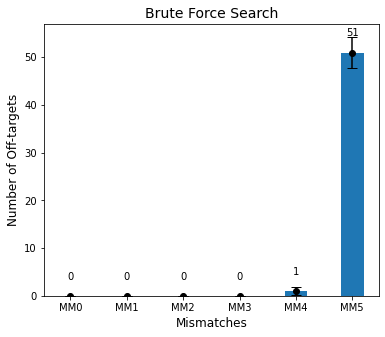

In [8]:
bar_labels = ['MM0', 'MM1', 'MM2', 'MM3', 'MM4', 'MM5']
bv_1 =  [sum(i) for i in zip(*mismatch_data_1)]
bv_2 =  [sum(i) for i in zip(*mismatch_data_2)]
bv_3 =  [sum(i) for i in zip(*mismatch_data_3)]

MM0 = [bv_1[0], bv_2[0], bv_3[0]]
MM1 = [bv_1[1], bv_2[1], bv_3[1]]
MM2 = [bv_1[2], bv_2[2], bv_3[2]]
MM3 = [bv_1[3], bv_2[3], bv_3[3]]
MM4 = [bv_1[4], bv_2[4], bv_3[4]]
MM5 = [bv_1[5], bv_2[5], bv_3[5]]

bar_values =  [np.mean(MM0) - np.mean([len(df_1),len(df_2),len(df_3)]), np.mean(MM1), np.mean(MM2), np.mean(MM3), np.mean(MM4), np.mean(MM5)]
bar_std =  [np.std([m - n for m, n in zip(MM0, [len(df_1),len(df_2),len(df_3)])]), np.std(MM1), np.std(MM2), np.std(MM3), np.std(MM4), np.std(MM5)]

fig = plt.figure(figsize = (6, 5))
bar_width = 0.4
# creating the bar plot 
plt.xlabel("Mismatches", fontsize=12)
plt.ylabel("Number of Off-targets", fontsize=12)
plt.title("Brute Force Search", fontsize=14)
bar = plt.bar(bar_labels, bar_values, bar_width, align='center')
(_, caps, _) = plt.errorbar(bar_labels, bar_values, yerr=bar_std, fmt="o", color='black', capsize=5)

for cap in caps:
    cap.set_markeredgewidth(1)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height + 3, f'{height:.0f}', ha='center', va='bottom')
    
#plt.show()
plt.savefig('Brute Force off-target check_v1.png', dpi = 400)